In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np
from torchvision import utils, transforms, datasets
from torch.utils.data import Subset
from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [3]:
from dataset_functions import *

In [4]:
torch.cuda.is_available()

True

In [5]:
data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        ToTensor()
])

dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                              root_dir='../../dataset/GTSRB',
                              transform=data_transform)

dataset_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

mean, std = get_mean_std_custom_dataset(dataset_loader)
print(mean, std)
# TODO: Export mean and std to be able to skip this step everytime this is run

tensor([0.3403, 0.3121, 0.3214]) tensor([0.2724, 0.2608, 0.2669])


In [6]:
training_data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        RandCrop(32),
        RandHorizFlip(0.5),
        RandVertFlip(0.5),
        # RandomRotation(),
        ToTensor(),
        CustomNormalize(mean, std)
    ])

validation_data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        ToTensor(),
        CustomNormalize(mean, std)
    ])

In [7]:
train_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                    root_dir='../../dataset/GTSRB',
                                    transform=training_data_transform)

valid_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                    root_dir='../../dataset/GTSRB',
                                    transform=validation_data_transform)

total_count = len(train_dataset)
train_count = int(0.8 * total_count)
print(total_count)
print(train_count)
indices = np.arange(0, total_count, 1)
np.random.seed(42)
np.random.shuffle(indices)
train_idx, val_idx = indices[:train_count], indices[train_count:]

train_dataset = Subset(train_dataset, train_idx)
valid_dataset = Subset(valid_dataset, val_idx)

39209
31367


In [8]:
print(train_dataset.dataset.transform)
print(valid_dataset.dataset.transform)

Compose(
)
Compose(
)


In [9]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

validation_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

In [10]:
def show_traffic_signs(sample_batched):
    """Show traffic signs for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

In [11]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

validation_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

0 torch.Size([64, 3, 32, 32])
1 torch.Size([64, 3, 32, 32])
2 torch.Size([64, 3, 32, 32])
3 torch.Size([64, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 torch.Size([64, 3, 32, 32])


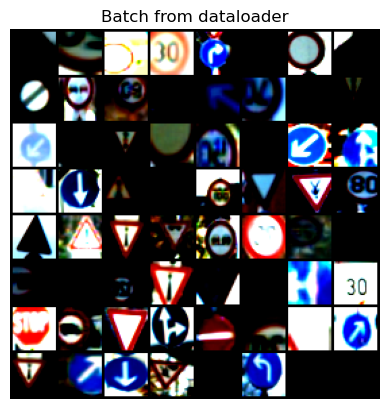

In [12]:
for i_batch, sample_batched in enumerate(train_dataset_loader):
    print(i_batch, sample_batched['image'].size())
    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_traffic_signs(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 torch.Size([64, 3, 32, 32]) tensor([10, 38, 25, 38, 35, 26, 38,  7,  5, 10,  8, 11, 33, 26, 10, 11, 17,  2,
        10, 33,  8, 18, 38, 14, 12, 41,  2, 38, 25, 38, 39, 13, 38,  7,  4, 23,
        38, 35, 38,  2,  2,  4, 12, 13, 12, 10,  0,  4, 25, 10, 11, 11, 12, 13,
        11, 16, 15, 31,  2, 10, 17,  7,  8, 17])
1 torch.Size([64, 3, 32, 32]) tensor([ 8, 11, 30, 15, 38,  2,  5,  9,  2, 42,  7, 21, 21, 23,  2, 38,  5,  7,
        13, 10,  5, 18,  3,  7, 26, 36, 12,  8, 11, 38,  0, 38, 31,  3,  4,  2,
        26, 16, 35,  4, 35, 41,  1, 30, 17, 38,  2, 11, 15, 10, 21, 25, 12,  7,
         8, 13, 17, 35,  5,  1, 10,  2, 40, 12])
2 torch.Size([64, 3, 32, 32]) tensor([30, 32,  2, 22, 13, 36, 13,  4, 20, 19,  1, 10, 11,  9,  5,  5, 10, 25,
         5, 26, 11,  2, 17,  7, 13, 14, 24, 38, 38, 15, 38, 27,  3, 13,  7,  4,
        28, 33, 32,  3, 21,  7, 10, 39,  1,  8,  7,  1, 37, 39, 36,  3,  2, 12,
         2,  8, 18, 25, 28,  4, 18, 10, 23,  5])
3 torch.Size([64, 3, 32, 32]) tensor([22, 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 torch.Size([64, 3, 32, 32]) tensor([ 4, 10, 36, 13, 40, 38, 12,  4, 19,  2,  2, 38, 38, 30, 10, 35, 12, 12,
         5,  1, 16, 16,  4,  2,  2, 13, 22, 11, 12, 13, 30, 30,  8, 12,  1, 12,
         3, 10, 31,  6, 25,  5, 18, 30, 25, 16, 10, 38, 12,  2, 13,  4, 25,  3,
        10, 18, 12, 10, 28, 28, 10,  2, 33,  4])


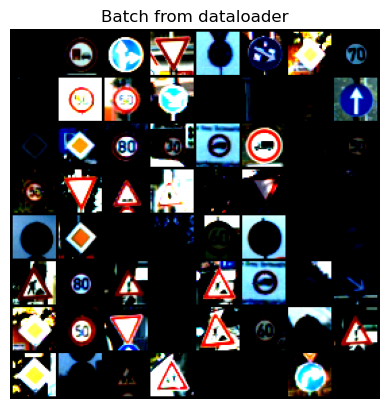

In [13]:
test_traffic_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Test.csv', 
                                           root_dir='../../dataset/GTSRB', transform=
                                           transforms.Compose([
                                            ConvertPIL(),
                                            Rescale((32, 32)),
                                            ToTensor(),
                                            CustomNormalize(mean, std)
                                        ]))

test_dataset_loader = torch.utils.data.DataLoader(test_traffic_dataset,
                                                batch_size=64,
                                                shuffle=True,
                                                num_workers=0)

for i_batch, sample_batched in enumerate(test_dataset_loader):
    # print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_traffic_signs(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [14]:
num_classes = len(train_dataset.dataset.get_classes())
print(num_classes)

from model import CustomCNN
net = CustomCNN(num_classes=num_classes)

43


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=43, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
EPOCHS = 5 # Load from a config file

In [18]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataset_loader):
        # Every data instance is an input + label pair
        inputs = data['image']
        labels = data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(train_dataset_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [19]:
best_vloss = 1_000_000.
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print('EPOCH {}:'.format(epoch_number + 1))
    running_loss = 0.
    last_loss = 0.

    net.train(True)
    avg_loss = train_one_epoch(epoch)

    running_vloss = 0.0

    # Set the model in evaluation mode
    net.eval()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for j, val_data in enumerate(validation_dataset_loader):
            inputs = val_data['image']
            labels = val_data['label']

            inputs, labels = inputs.to(device), labels.to(device)
            
            target = net(inputs)
            vloss = criterion(target, labels)
            running_vloss += vloss
    
        avg_vloss = running_vloss / (j + 1)
        print('LOSS train {} validation {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        # writer.add_scalars('Training vs. Validation Loss',
        #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
        #                 epoch_number + 1)
        # writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            torch.save(net.state_dict(), model_path)
        
        epoch_number += 1

EPOCH 1:
batch 100 loss: 3.453867313861847
batch 200 loss: 3.17643515586853
batch 300 loss: 3.086872055530548
batch 400 loss: 2.98681391954422
LOSS train 2.98681391954422 validation 2.6439123153686523
EPOCH 2:
batch 100 loss: 2.824813048839569
batch 200 loss: 2.7198866391181946
batch 300 loss: 2.6511328744888307
batch 400 loss: 2.579983606338501
LOSS train 2.579983606338501 validation 2.18345308303833
EPOCH 3:
batch 100 loss: 2.55592410326004
batch 200 loss: 2.4724868726730347
batch 300 loss: 2.4292603278160096
batch 400 loss: 2.318067545890808
LOSS train 2.318067545890808 validation 1.9216769933700562
EPOCH 4:
batch 100 loss: 2.368747133016586
batch 200 loss: 2.264116654396057
batch 300 loss: 2.261379361152649
batch 400 loss: 2.2360332918167116
LOSS train 2.2360332918167116 validation 1.8053661584854126
EPOCH 5:
batch 100 loss: 2.1813903844356535
batch 200 loss: 2.114579887390137
batch 300 loss: 2.133931738138199
batch 400 loss: 2.1503944969177247
LOSS train 2.1503944969177247 validat

In [20]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

net.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, test_data in enumerate(test_dataset_loader):
        inputs = test_data['image']
        labels = test_data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 58 %


In [21]:
# TODO
# add more transformations
# increase the number of layers
# add dropout